# Intro

We perform Multi-Task training using aleatoric homoscedastic uncertainty (https://arxiv.org/pdf/1705.07115.pdf) on toy data. 

# Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate, Layer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import Constant

%matplotlib inline

Using TensorFlow backend.


# Create toy dataset

Create toy dataset with 2 regression targets for multi-task learning

In [4]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3
out_dims = 2

X = np.random.uniform(0, max_tr, size=N)
X_val = np.random.uniform(min_val, max_val, N_val)

# Training
Y = np.zeros((N,2))
Y[:, 0] = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)
Y[:, 1] = np.cos(X) + np.random.normal(loc=0, scale=0.1, size=N)

# Validation
Y_val = np.zeros((N_val,2))
Y_val[:, 0] = np.sin(X_val) + np.random.normal(loc=0, scale=0.3, size=N_val)
Y_val[:, 1] = np.cos(X_val) + np.random.normal(loc=0, scale=0.1, size=N_val)

Visualize data

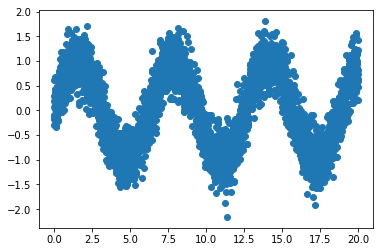

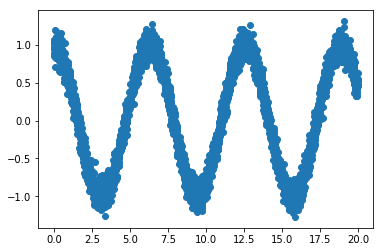

In [5]:
for i in range(Y.shape[1]):
    plt.figure()
    plt.scatter(X, Y[:, i])
    plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [6]:
# Hyperparameters
lr = 0.001
lr_mult = 0.001
batch_size = 128
epochs = 500
patience = 20
modes = 1

Custom loss layer implementation by Yarin Gal (https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb):

In [7]:
# Custom loss layer
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

In [8]:
def get_multi_task_model(model):
    
    inp = Input(shape=(1,), name='inp')
    y1_pred, y2_pred = model(inp)
    
    y1_true = Input(shape=(1,), name='y1_true')
    y2_true = Input(shape=(1,), name='y2_true')
    
    out = CustomMultiLossLayer(nb_outputs=out_dims)([y1_true, y2_true, y1_pred, y2_pred])
    
    return Model([inp, y1_true, y2_true], out)

def get_model(with_multi_task=False):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(100, activation='relu')(dense)
    
    out1 = Dense(1, name='out1')(dense)
    out2 = Dense(1, name='out2')(dense)
    
    model = Model(inputs=[inp], outputs=[out1, out2])
    
    if with_multi_task:
        model = get_multi_task_model(model)
        model.compile(Adam(lr=lr), loss=None)
    else:
        model.compile(Adam(lr=lr), loss='mse')
    
    return model

Fit normal dense model to data

In [9]:
model = get_model(with_multi_task=False)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
out1 (Dens

In [11]:
model.fit(
    x = X,
    y = [Y[:, 0], Y[:, 1]],
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, [Y_val[:, 0], Y_val[:, 1]]],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/500
4000/4000 [==============================] - 1s 214us/step - loss: 1.1293 - out1_loss: 0.5913 - out2_loss: 0.5380 - val_loss: 1.0848 - val_out1_loss: 0.5898 - val_out2_loss: 0.4949
Epoch 2/500
4000/4000 [==============================] - 0s 23us/step - loss: 1.0692 - out1_loss: 0.5722 - out2_loss: 0.4970 - val_loss: 1.0177 - val_out1_loss: 0.5594 - val_out2_loss: 0.4583
Epoch 3/500
4000/4000 [==============================] - 0s 23us/step - loss: 1.0268 - out1_loss: 0.5520 - out2_loss: 0.4747 - val_loss: 0.9748 - val_out1_loss: 0.5376 - val_out2_loss: 0.4372
Epoch 4/500
4000/4000 [==============================] - 0s 23us/step - loss: 0.9922 - out1_loss: 0.5274 - out2_loss: 0.4647 - val_loss: 0.9657 - val_out1_loss: 0.5181 - val_out2_loss: 0.4476
Epoch 5/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.9586 - out1_loss: 0.5091 - out2_loss: 0.4494 - val_loss: 0.9160 - val_out1_loss: 0.5020 - val_out2_loss

4000/4000 [==============================] - 0s 24us/step - loss: 0.5296 - out1_loss: 0.3136 - out2_loss: 0.2159 - val_loss: 0.5222 - val_out1_loss: 0.3089 - val_out2_loss: 0.2134
Epoch 44/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.5146 - out1_loss: 0.3083 - out2_loss: 0.2063 - val_loss: 0.5255 - val_out1_loss: 0.3051 - val_out2_loss: 0.2204
Epoch 45/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.5049 - out1_loss: 0.3062 - out2_loss: 0.1987 - val_loss: 0.5192 - val_out1_loss: 0.3071 - val_out2_loss: 0.2121
Epoch 46/500
4000/4000 [==============================] - 0s 23us/step - loss: 0.4936 - out1_loss: 0.3049 - out2_loss: 0.1887 - val_loss: 0.4976 - val_out1_loss: 0.3137 - val_out2_loss: 0.1839
Epoch 47/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.4800 - out1_loss: 0.3009 - out2_loss: 0.1792 - val_loss: 0.4984 - val_out1_loss: 0.2987 - val_out2_loss: 0.1997
Epoch 48/500
4000/4000 [========================

4000/4000 [==============================] - 0s 23us/step - loss: 0.1267 - out1_loss: 0.0998 - out2_loss: 0.0269 - val_loss: 0.1314 - val_out1_loss: 0.1079 - val_out2_loss: 0.0235
Epoch 86/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.1240 - out1_loss: 0.0991 - out2_loss: 0.0249 - val_loss: 0.1298 - val_out1_loss: 0.1050 - val_out2_loss: 0.0248
Epoch 87/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.1300 - out1_loss: 0.1047 - out2_loss: 0.0254 - val_loss: 0.1358 - val_out1_loss: 0.1126 - val_out2_loss: 0.0232
Epoch 88/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.1295 - out1_loss: 0.1019 - out2_loss: 0.0276 - val_loss: 0.1402 - val_out1_loss: 0.1035 - val_out2_loss: 0.0367
Epoch 89/500
4000/4000 [==============================] - 0s 24us/step - loss: 0.1287 - out1_loss: 0.1020 - out2_loss: 0.0267 - val_loss: 0.1248 - val_out1_loss: 0.1028 - val_out2_loss: 0.0220
Epoch 90/500
4000/4000 [========================

Visualize prediction

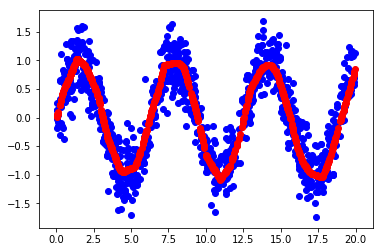

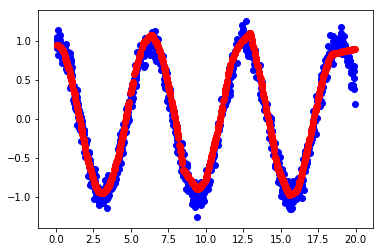

In [12]:
preds = model.predict(X_val)

for i in range(Y.shape[1]):
    plt.figure()
    plt.scatter(X_val, Y_val[:, i], color='b')
    plt.scatter(X_val, preds[i], color='r')
    plt.show()

Train model with Multi-Task loss

In [13]:
model_mult = get_model(with_multi_task=True)

In [14]:
model_mult.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
y1_true (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
y2_true (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 1), (None, 1 20602       inp[0][0]                        
__________________________________________________________________________________________________
custom_mul

In [15]:
model_mult.fit(
    x = [X, Y[:, 0], Y[:, 1]],
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Epoch 1/500
4000/4000 [==============================] - 0s 99us/step - loss: 1.1118
Epoch 2/500
4000/4000 [==============================] - 0s 23us/step - loss: 1.0273
Epoch 3/500
4000/4000 [==============================] - 0s 23us/step - loss: 0.9508
Epoch 4/500
 128/4000 [..............................] - ETA: 0s - loss: 0.9237

/home/postelja/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4000/4000 [==============================] - 0s 24us/step - loss: 0.8954
Epoch 5/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.8374
Epoch 6/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.7860
Epoch 7/500
4000/4000 [==============================] - 0s 23us/step - loss: 0.7442
Epoch 8/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.7038
Epoch 9/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.6662
Epoch 10/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.6276
Epoch 11/500
4000/4000 [==============================] - 0s 22us/step - loss: 0.5852
Epoch 12/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.5431
Epoch 13/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.4965
Epoch 14/500
4000/4000 [==============================] - 0s 21us/step - loss: 0.4617
Epoch 15/500
4000/4000 [==============================] - 0s 22us/step -

4000/4000 [==============================] - 0s 22us/step - loss: -4.1976
Epoch 99/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.2554
Epoch 100/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.3221
Epoch 101/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.2570
Epoch 102/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.2198
Epoch 103/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.3263
Epoch 104/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.1840
Epoch 105/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.1970
Epoch 106/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.3635
Epoch 107/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.4526
Epoch 108/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.4263
Epoch 109/500
4000/4000 [======================

4000/4000 [==============================] - 0s 22us/step - loss: -4.6172
Epoch 192/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.6797
Epoch 193/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.7345
Epoch 194/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.7543
Epoch 195/500
4000/4000 [==============================] - 0s 24us/step - loss: -4.7050
Epoch 196/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.7772
Epoch 197/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.7325
Epoch 198/500
4000/4000 [==============================] - 0s 23us/step - loss: -4.4898
Epoch 199/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.7612
Epoch 200/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.6781
Epoch 201/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.7583
Epoch 202/500
4000/4000 [=====================

4000/4000 [==============================] - 0s 21us/step - loss: -4.8366
Epoch 285/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.6551
Epoch 286/500
4000/4000 [==============================] - 0s 27us/step - loss: -4.8551
Epoch 287/500
4000/4000 [==============================] - 0s 24us/step - loss: -4.7765
Epoch 288/500
4000/4000 [==============================] - 0s 23us/step - loss: -4.5476
Epoch 289/500
4000/4000 [==============================] - 0s 25us/step - loss: -4.5555
Epoch 290/500
4000/4000 [==============================] - 0s 26us/step - loss: -4.8204
Epoch 291/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.7797
Epoch 292/500
4000/4000 [==============================] - 0s 23us/step - loss: -4.7260
Epoch 293/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.7973
Epoch 294/500
4000/4000 [==============================] - 0s 23us/step - loss: -4.7433
Epoch 295/500
4000/4000 [=====================

4000/4000 [==============================] - 0s 27us/step - loss: -4.8162
Epoch 378/500
4000/4000 [==============================] - 0s 26us/step - loss: -4.8174
Epoch 379/500
4000/4000 [==============================] - 0s 25us/step - loss: -4.7066
Epoch 380/500
4000/4000 [==============================] - 0s 25us/step - loss: -4.7538
Epoch 381/500
4000/4000 [==============================] - 0s 26us/step - loss: -4.8492
Epoch 382/500
4000/4000 [==============================] - 0s 28us/step - loss: -4.8701
Epoch 383/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.8019
Epoch 384/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.8828
Epoch 385/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.6348
Epoch 386/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.7020
Epoch 387/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.8593
Epoch 388/500
4000/4000 [=====================

4000/4000 [==============================] - 0s 24us/step - loss: -4.7312
Epoch 471/500
4000/4000 [==============================] - 0s 25us/step - loss: -4.8910
Epoch 472/500
4000/4000 [==============================] - 0s 24us/step - loss: -4.8147
Epoch 473/500
4000/4000 [==============================] - 0s 22us/step - loss: -4.7431
Epoch 474/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.7931
Epoch 475/500
4000/4000 [==============================] - 0s 19us/step - loss: -4.7912
Epoch 476/500
4000/4000 [==============================] - 0s 19us/step - loss: -4.8261
Epoch 477/500
4000/4000 [==============================] - 0s 19us/step - loss: -4.7790
Epoch 478/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.6894
Epoch 479/500
4000/4000 [==============================] - 0s 20us/step - loss: -4.8390
Epoch 480/500
4000/4000 [==============================] - 0s 21us/step - loss: -4.8312
Epoch 481/500
4000/4000 [=====================

In [16]:
pred_model = model_mult.layers[-2]

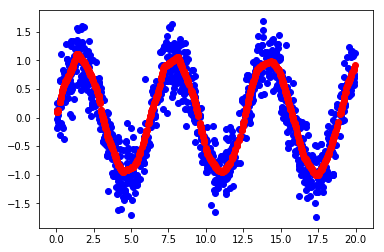

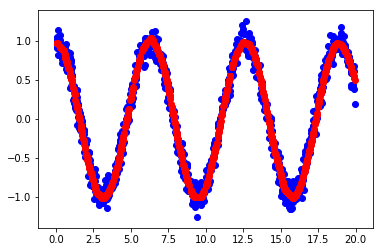

In [17]:
mult_preds = pred_model.predict(X_val)

for i in range(Y.shape[1]):
    plt.figure()
    plt.scatter(X_val, Y_val[:, i], color='b')
    plt.scatter(X_val, mult_preds[i], color='r')
    plt.show()

Estimated homoscedastic uncertainty

In [18]:
[np.exp(K.get_value(log_var[0]))**0.5 for log_var in model_mult.layers[-1].log_vars]

[0.3029894707702567, 0.10810507780312799]

# Error

Comparing the errors

In [19]:
error = np.mean(np.abs(np.concatenate(preds, axis=1) - Y_val))
mult_error = np.mean(np.abs(np.concatenate(mult_preds, axis=1) - Y_val))

print('Error normal: ' + str(error))
print('Error Multi-task: ' + str(mult_error))

Error normal: 0.17655513580843432
Error Multi-task: 0.1656800463454936
